# SGAN

半监督生成对抗网络（Semi-Supervised GAN，SGAN）是一种生成对抗网络，其鉴别器是多分类器。这里的鉴别器不只是区分两个类（真和假），而是学会区分N+1类，其中N是训练数据集中的类数，生成器生成的伪样本增加了一个类。

## 结构区别

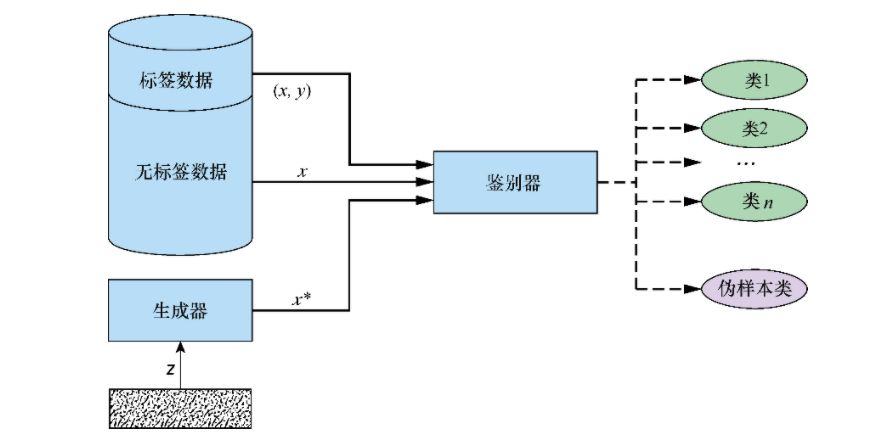

与传统GAN相比，SGAN区分多个类的任务不仅影响了鉴别器本身，还增加了SGAN架构、训练过程和训练目标的复杂性。

SGAN生成器的目的与原始GAN相同：接收一个随机数向量并生成伪样本，力求使伪样本与训练数据集别无二致。但是，SGAN鉴别器与原始GAN实现有很大不同。它接收3种输入：生成器生成的伪样本X*、训练数据集中无标签的真实样本X和有标签的真实样本X,y。其中y表示给定样本X的标签。

## 训练区别 

除了计算判别器的损失值，还必须计算有监督训练样本的损失：D(x,y)。所以说，SCAN有两种损失值：有监督损失和无监督损失。

在SGAN中主要关心的反而是鉴别器。训练过程的目标是使该网络成为仅使用一小部分标签数据的半监督分类器，其准确率尽可能接近全监督的分类器（其训练数据集中的每个样本都有标签）。生成器的目标是通过提供附加信息（它生成的伪数据）来帮助鉴别器学习数据中的相关模式，从而提高其分类准确率。训练结束时，生成器将被丢弃，而训练有素的鉴别器将被用作分类器。

## SGAN的实现

结构图
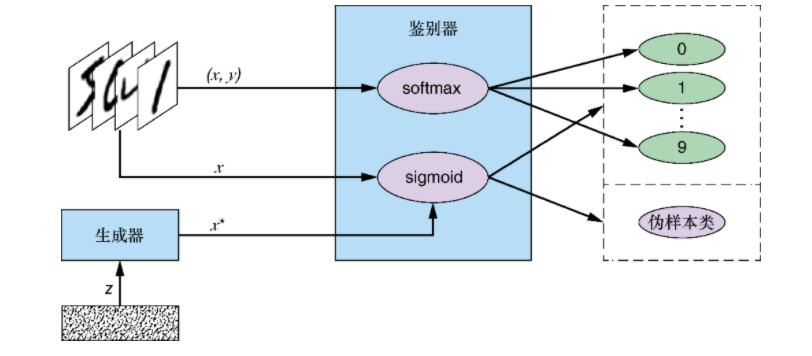


为了解决区分真实标签的多分类问题，鉴别器使用了softmax函数，该函数给出了在给定数量的类别（本例中为10类）上的概率分布。给一个给定类别标签分配的概率越高，鉴别器就越确信该样本属于这一给定的类。为了计算分类误差，使用了交叉熵损失，以测量输出概率与目标独热编码标签之间的差异。

In [1]:
# 导入包
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K
from keras.datasets import mnist
from keras.layers import Dropout, Lambda, Concatenate, Input, Dense, Flatten, Reshape, Activation, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
# 模型输入维度
img_rows = 28
img_cols = 28
channels = 1
# 图像大小
img_shape = (img_rows, img_cols, channels)
# 噪声向量大小
z_dim = 100

num_classes = 10

尽管MNIST训练数据集里有50000个有标签的训练图像，但我们仅将其中的一小部分（由num_labeled参数决定）用于训练，并假设其余图像都是无标签的。我们这样来实现这一点：取批量有标签数据时仅从前num_labeled个图像采样，而在取批量无标签数据时从其余（50000 – num_labeled）个图像中采样。

In [3]:
class Dataset:
    def __init__(self, num_labeled):
        self.num_labeled = num_labeled
        mnist=tf.keras.datasets.mnist
        (self.x_train, self.y_train), (self.x_test, self.y_test) = mnist.load_data('./MNIST')
        def preprocess_imgs(X):
            X = (X.astype(np.float32) - 127.5)/127.5
            X = np.expand_dims(X, axis=3)
            return X
        def preprocess_labels(y):
            return y.reshape(-1, 1)
        self.x_train = preprocess_imgs(self.x_train)
        self.y_train = preprocess_labels(self.y_train)
        self.x_test = preprocess_imgs(self.x_test)
        self.y_test = preprocess_labels(self.y_test)
    def batch_labeled(self, batch_size):
        idx = np.random.randint(0, self.num_labeled, batch_size)
        imgs = self.x_train[idx]
        labels = self.y_train[idx]
        return imgs, labels
    def batch_unlabeled(self, batch_size):
        idx = np.random.randint(self.num_labeled, self.x_train.shape[0], batch_size)
        imgs = self.x_train[idx]
        return imgs
    def training_set(self):
        x_train = self.x_train[range(self.num_labeled)]
        y_train = self.y_train[range(self.num_labeled)]
        return x_train, y_train
    def test_set(self):
        return self.x_test, self.y_test

In [4]:
num_labeled = 100

dataset = Dataset(num_labeled)

## 生成器

In [5]:
def build_generator(z_dim):
    model = Sequential()
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))
    model.add(Activation('tanh'))
    return model

## 判别器

In [6]:
def build_discriminator_net(img_shape):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape,padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=img_shape,padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(128, kernel_size=3, strides=2, input_shape=img_shape,padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(num_classes))
    return model

有监督的判别器

In [7]:
def bulid_discriminator_supervised(discriminator_net):
    model = Sequential()
    model.add(discriminator_net)
    model.add(Activation('softmax'))
    return model

无监督的判别器

In [8]:
def build_discriminator_unsupervised(discriminator_net):
    model = Sequential()
    model.add(discriminator_net)
    def predict(x):
        prediction = 1.0 - (1.0/ K.sum(K.exp(x), axis=-1, keepdims=True) + 1.0)
        return prediction
    model.add(Lambda(predict))

    return model

In [15]:
def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model
discriminator_net = build_discriminator_net(img_shape)
discriminator_supervised = bulid_discriminator_supervised(discriminator_net)
discriminator_supervised.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
discriminator_unsupervised = build_discriminator_unsupervised(discriminator_net)
discriminator_unsupervised.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
generator = build_generator(z_dim)
discriminator_unsupervised.trainable = False

gan = build_gan(generator, discriminator_unsupervised)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [16]:
supervised_losses = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
#     print(fake.shape)
    
    for iteration in range(iterations):
        imgs, labels = dataset.batch_labeled(batch_size)
#         print(imgs.shape)
        labels = to_categorical(labels, num_classes=num_classes)
#         print(labels.shape)
        imgs_unlabeled = dataset.batch_unlabeled(batch_size)
#         print(imgs_unlabeled.shape)
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict(z)
#         imgs = imgs.reshape(28, 28, 32)
        d_loss_supervised, accuracy = discriminator_supervised.train_on_batch(imgs, labels)
        d_loss_real = discriminator_unsupervised.train_on_batch(imgs_unlabeled, real)
        d_loss_fake = discriminator_unsupervised.train_on_batch(gen_imgs, fake)
        d_loss_unsupervised = 0.5 *np.add(d_loss_real, d_loss_fake)
#         print('begin')
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict(z)
        g_loss = gan.train_on_batch(z, np.ones((batch_size, 1)))
        if (iteration + 1) % sample_interval == 0:
            supervised_losses.append(d_loss_supervised)
            iteration_checkpoints.append(iteration + 1)
            print((iteration + 1, d_loss_supervised, 100.0 * accuracy, (d_loss_unsupervised[0],g_loss)))
#             print("%d [D loss: %.4f, acc.: %.2f%%] [D loss" + "unsupervised:%.4f][G loss:%.4f]" % (iteration + 1, d_loss_supervised, 100.0 * accuracy, (d_loss_unsupervised[0] ,g_loss)))

In [17]:
iterations  = 8000
batch_size = 32
sample_interval = 800
train(iterations, batch_size, sample_interval)

(800, 0.00036323818, 100.0, (8.059048, 16.118095))
(1600, 4.344091e-05, 100.0, (8.059048, 16.118095))
(2400, 1.1580256e-05, 100.0, (8.059048, 16.118095))
(3200, 1.6784854e-05, 100.0, (8.059048, 16.118095))
(4000, 1.2563807e-05, 100.0, (8.059048, 16.118095))
(4800, 2.6151722e-06, 100.0, (8.059048, 16.118095))
(5600, 2.9057446e-06, 100.0, (8.059048, 16.118095))
(6400, 7.3760907e-07, 100.0, (8.059048, 16.118095))
(7200, 7.879003e-07, 100.0, (8.059048, 16.118095))
(8000, 1.5404223e-06, 100.0, (8.059048, 16.118095))


全监督分类器

In [18]:
mnist_classifier = bulid_discriminator_supervised(build_discriminator_net(img_shape))
mnist_classifier.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])